In [61]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential #regroupement de layer formant le modele
#dense == tensor ou layer ou ensemble de neurons d'un mm niveau 
 
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU #layer instance

#import la fct elu pour pouvoir gerer HP alpha
from tensorflow.keras.activations import relu
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, TensorBoard

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

import numpy as np
import random
import time


In [62]:
###PREP TENSOR BOARD###

NAME = "CHF_hp_test_{}".format(int(time.time()))
#pour avoir un resumé sur tensorboard
log_dir = "./logs/{}".format(NAME)  # Specify the directory where logs will be stored
tb = TensorBoard(log_dir=log_dir, histogram_freq=1)



In [63]:

###HYPERPARAM###
# type d'archi qu'on veut 
architecture = [5,39, 40, 31, 42, 1]#small
#architecture = [5,61,51,28,39,26,2120,14,1]

dropoutRate = 0.1 #0.2 40% #on peut pt retirer car batch
learningRate = 0.001  #peut etre augmenter car batchnormalisation # ou peut etre plus vite decroitre
expDecay = 0.97
rythm = 32
testPercent = 0.2
maxEpochs = 850 #pas trop important car peut de chance d'overfitt
thresholdActi = 0
#! >=0  = pente pour tt x en dessous de thresold
alphaActi = 0.1 # 0.1 15% 0.3 25%S  ,36% pr 0.15
clipGrad = 1

seed_pre_shuffle = 51 #for numpy
seed_split = 41
seed_tf = 61
seed_python = 31 
seed_numpy = 71


loss_function = MeanSquaredLogarithmicError()
other_metrics = ['mape', 'accuracy']

monitorParam = 'loss'
loss_delta_stop = 0.1
batchSize = 32 #pt 16


### ###


In [64]:
###SEED###

#seed for weights and all
tf.random.set_seed(seed_tf)

#seed for data shuffle
np.random.seed(seed_numpy)

#python seed to be sure
random.seed(seed_python)

In [65]:
###LOAD DATA###

data = pd.read_csv('./src/sort.csv') 

#pre shuffle 
data = data.sample(frac=1, random_state=seed_pre_shuffle)




features = data.iloc[:, 1:6].values #inputs
targets = data.iloc[:, 7].values #target outputs

# normalisation std
scaler = StandardScaler()
features = scaler.fit_transform(features)

#normalized_targets = (targets - np.mean(targets)) / np.std(targets)


##import to save bc use it when want to predict
mean_value = scaler.mean_
std_deviation = scaler.scale_

#new_data = scaler.transform(new_data) to the input for prediction


X_train, X_val, y_train, y_val = train_test_split(features, 
                                                  targets, 
                                                  test_size=testPercent, 
                                                  random_state=seed_split)


In [66]:
###ACTIVATION###

#actMethod = relu
actMethod = LeakyReLU(alpha=alphaActi)

In [67]:
###INIT MODEL###


model = Sequential()
# Add the layers

for layer, neurons in enumerate(architecture):
    
    if layer != len(architecture)-1:
        model.add(
            Dense(
                neurons, 
                activation=actMethod,#(alpha=alphaActi, threshold=thresholdActi), 
                input_shape=(neurons,)
                )
        )
        
    if layer == len(architecture) -1: #maybe sigmoid act
        model.add(
            Dense(
                neurons, 
                activation=actMethod,#'relu',#'linear',#(alpha=alphaActi, threshold=thresholdActi), 
                input_shape=(neurons,)
                )
        )
    if layer == 1 or layer == 2:
        model.add(Dropout(dropoutRate))
    if layer != 0 and layer != len(architecture) - 1:
        model.add(BatchNormalization())



model.compile(optimizer=Adam(learning_rate=learningRate), 
              loss=loss_function, metrics=other_metrics)



In [54]:
###CALLBACKS###

#== modification/monitoring durant l'entrainement
#on stop qd plus de chgmt apres 50 epoch
early_stop = EarlyStopping(monitor=monitorParam,          #mieux de monitorer la loss car moins variable 
                           min_delta=loss_delta_stop,             #if nothing precise, it will check loss and stop after no change of >=0.1
                           patience=50, verbose=1,
                           restore_best_weights=True) #when stop ensure we keep best perf

# tt les 32 epochs lr perd 4%
#schedule == function to give to LearningScheduler, with epoch and lr as param
def lr_scheduler(epoch, lr):          #to modify and/or add to HP   
    if epoch % rythm == 0 and epoch > 0:
        return lr * expDecay
    return lr

learningRateScheduler = LearningRateScheduler(lr_scheduler)



"\n#create my own callback to monitor average precision error\nclass MPACallback(tf.keras.callbacks.Callback):\n    def __init__(self, validation_data):\n        super(MPACallback, self).__init__()\n        self.validation_data = validation_data\n        self.previous_predictions = None\n\n    def on_epoch_end(self, epoch, logs=None):\n        if epoch % 10 == 0:\n            val_predictions = self.model.predict(self.validation_data[0]) #check the prediction based on non seen data\n            val_targets = self.validation_data[1] \n            mpa = 100 - (np.mean(np.abs((val_targets - val_predictions) / val_targets)) * 100.0)\n            logs['mpa'] = mpa #to add to history\n            # Log MPE to TensorBoard\n            tf.summary.scalar('MPA', data=mpa, step=epoch)\n\nmpa_callback = MPACallback(validation_data=(X_val, y_val))\n"

In [55]:
###TRAINING###

#a partir d'ici que les weigghts sont crée 
history = model.fit(X_train, y_train,
                    shuffle=False,                  #comme ça on le fait ns mm avec une seed
                    validation_data=(X_val,y_val),
                    batch_size=batchSize, epochs=maxEpochs,
                    callbacks=[early_stop, learningRateScheduler, tb], #mpa_callback
                    verbose=1)                                    #progress bar

# resumé
model.summary()

Epoch 1/850
600/600 [==============================] - 6s 5ms/step - loss: 99.9963 - val_loss: 99.9920 - lr: 0.0010
Epoch 2/850
600/600 [==============================] - 3s 5ms/step - loss: 99.9821 - val_loss: 99.9679 - lr: 0.0010
Epoch 3/850
600/600 [==============================] - 3s 5ms/step - loss: 99.9570 - val_loss: 99.9392 - lr: 0.0010
Epoch 4/850
600/600 [==============================] - 3s 5ms/step - loss: 99.9225 - val_loss: 99.8947 - lr: 0.0010
Epoch 5/850
600/600 [==============================] - 3s 5ms/step - loss: 99.8797 - val_loss: 99.8439 - lr: 0.0010
Epoch 6/850
600/600 [==============================] - 3s 5ms/step - loss: 99.8288 - val_loss: 99.7929 - lr: 0.0010
Epoch 7/850
600/600 [==============================] - 3s 5ms/step - loss: 99.7709 - val_loss: 99.6916 - lr: 0.0010
Epoch 8/850
600/600 [==============================] - 3s 5ms/step - loss: 99.7069 - val_loss: 99.6446 - lr: 0.0010
Epoch 9/850
600/600 [==============================] - 3s 5ms/step - los

loss


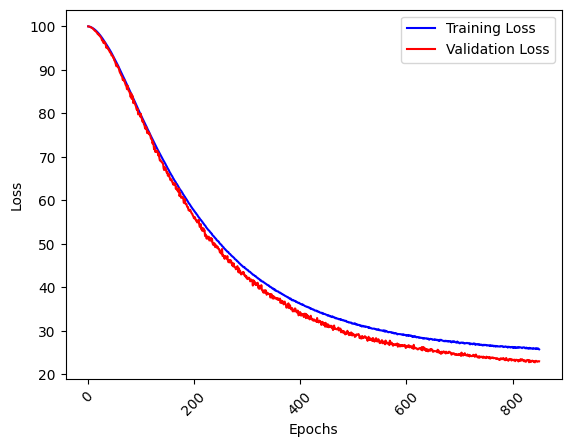

ok


In [57]:
###PLOT PERFORMANCE###
print(monitorParam)
import matplotlib.pyplot as plt

# Get the loss history from the model training
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the loss curves
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(rotation=45)



#plt.savefig('loss_plot1.png')

plt.show()
print("ok")

In [58]:
predictions = model.predict(X_val)
mpe = np.mean(np.abs(y_val - predictions) / y_val) * 100
print("pourcentage moyen d'erreur relative final  : ", mpe)

m = np.mean(y_val/predictions)
std = np.std(y_val/predictions)
print("mean :",m,"std :", std)


nrmse = np.sqrt(np.mean(np.square(predictions - y_val))) / (np.max(y_val) - np.min(y_val))

print("NRMSE:", nrmse)

msle = np.mean(np.square(np.log(predictions) - np.log(y_val)))




150/150 [==============================] - 0s 2ms/step
pourcentage moyen d'erreur relative final  :  91.12572229598321
mean : -0.5721511991597902 std : 80.19733753010594
NRMSE: 0.12661662909752858


/tmp/ipykernel_3483/2347102040.py:14: RuntimeWarning: invalid value encountered in log
  msle = np.mean(np.square(np.log(predictions) - np.log(y_val)))


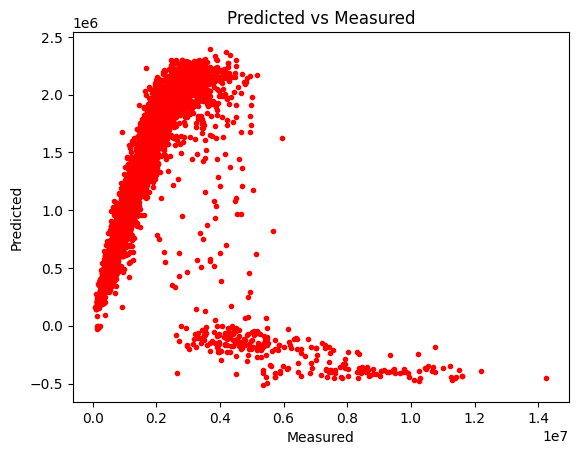

In [59]:
plt.figure()

plt.plot(y_val, predictions, '.r', label='')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predicted vs Measured')
plt.show()

In [60]:


mpa_values = history.history['mpa']

# Plot the MPA values
epochs = range(0, len(mpa_values) * 10, 10)
plt.plot(epochs, mpa_values, label='MPA')
plt.xlabel('Epochs')
plt.ylabel('MPA')
plt.title('Mean Percentage Accuracy (MPA) Evolution')
plt.legend()
plt.show()


KeyError: 'mpa'